# Outliers Detection Methods

This notebook runs and experiments **outlier detection** using two families of methods:

- **Statistical methods**: Z-Score, IQR, Leverae, Cook's Distance, Mahalanobis Distance
- **Machine Learning methods**: Elliptic Envelope, Isolation Forest, Local Outlier Factor, One-Class SVM, SGD One-Class SVM

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import qmc
import statsmodels.api as sm
from pymoo.problems import get_problem
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDOneClassSVM, LinearRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Statistical Diagnostics

On this statistical diagnostics we are going to implement residuals, studentized residuals, leverage, DFFITS & Cook’s Distance.


### Iris dataset

In [3]:
# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

X_model = X.drop(columns=['sepal length (cm)'])
y_model = X['sepal length (cm)']

# Adding intercept for statsmodels
X_model_const = sm.add_constant(X_model)

# Fit OLS model
model = sm.OLS(y_model, X_model_const).fit()

# Get influence measures
influence = model.get_influence()
summary_frame = influence.summary_frame()

# Add diagnostics to DataFrame
X['residuals'] = model.resid
X['studentized_residuals'] = summary_frame['student_resid']
X['leverage'] = summary_frame['hat_diag']
X['dffits'] = summary_frame['dffits']
X['cooks_distance'] = summary_frame['cooks_d']

# Show top outliers by Cook's Distance
outliers = X.sort_values('cooks_distance', ascending=False).head()
print(outliers[['residuals', 'studentized_residuals', 'leverage', 'dffits', 'cooks_distance']])

     residuals  studentized_residuals  leverage    dffits  cooks_distance
141   0.689744               2.291006  0.057232  0.564472        0.077405
134  -0.640237              -2.130018  0.064736 -0.560387        0.076652
106  -0.828164              -2.727692  0.027227 -0.456337        0.049861
135   0.845696               2.780593  0.021968  0.416728        0.041502
14    0.600992               1.969489  0.040304  0.403608        0.039937


### Interquartile Range (IQR)

In [4]:
def calculate_iqr(data):
    """Calculate Interquartile Range (IQR) for outlier detection."""
    data_array = np.array(data)

    q1 = np.percentile(data_array, 25)
    q3 = np.percentile(data_array, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return q1, q3, lower_bound, upper_bound


def detect_outliers_iqr(data):
    """Detect outliers using IQR method."""
    data_array = np.array(data)
    q1, q3, lower_bound, upper_bound = calculate_iqr(data_array)

    is_outlier = (data_array < lower_bound) | (data_array > upper_bound)
    outliers = data_array[is_outlier]
    
    return outliers, is_outlier

### IQR Test on "LotArea" attribute of "House Pricing Dataset"

In [5]:
train_df = pd.read_csv('train.csv')

q1, q3, lower_bound, upper_bound = calculate_iqr(train_df['LotArea'])
outliers, is_outlier_mask = detect_outliers_iqr(train_df['LotArea'])

print(f"LotArea Statistics:")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Lower bound for outliers: {lower_bound:.2f}")
print(f"Upper bound for outliers: {upper_bound:.2f}")
print(f"Number of outliers detected: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers) / len(train_df)) * 100:.2f}%")

LotArea Statistics:
Q1 (25th percentile): 7553.50
Q3 (75th percentile): 11601.50
Lower bound for outliers: 1481.50
Upper bound for outliers: 17673.50
Number of outliers detected: 69
Percentage of outliers: 4.73%


### Comparing Feature before and after outlier detection

In [6]:
train_df_clean = train_df[~is_outlier_mask]
print(f"\nOriginal dataset size: {len(train_df)}")
print(f"Clean dataset size after removing outliers: {len(train_df_clean)}")


Original dataset size: 1460
Clean dataset size after removing outliers: 1391


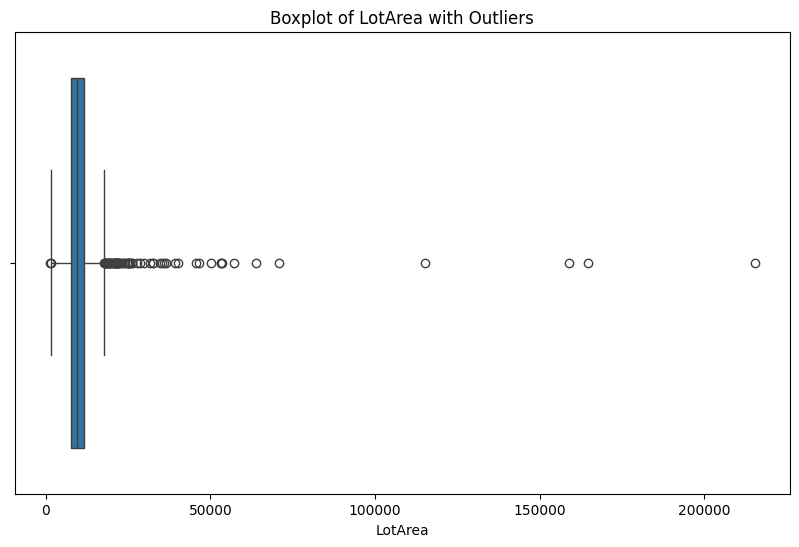

In [7]:
# Boxplot to visualize the distribution and outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['LotArea'])
plt.title('Boxplot of LotArea with Outliers')
plt.xlabel('LotArea')
plt.show()

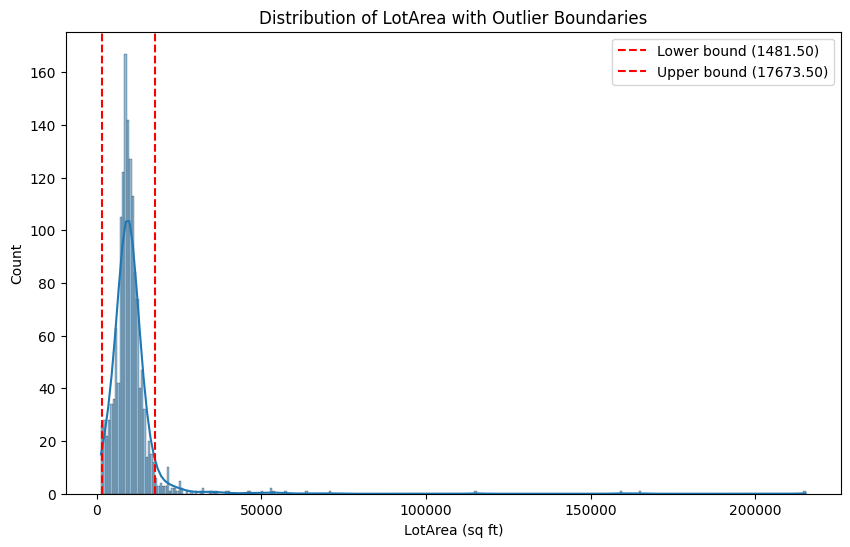

In [8]:
# Histogram to show the distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['LotArea'], kde=True)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
plt.title('Distribution of LotArea with Outlier Boundaries')
plt.xlabel('LotArea (sq ft)')
plt.legend()
plt.show()

In [9]:
# Compare statistics before and after outlier removal
print("\nStatistics before outlier removal:")
print(train_df['LotArea'].describe())
print("\nStatistics after outlier removal:")
print(train_df_clean['LotArea'].describe())


Statistics before outlier removal:
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Statistics after outlier removal:
count     1391.000000
mean      9272.537024
std       3196.732418
min       1491.000000
25%       7429.000000
50%       9286.000000
75%      11231.500000
max      17671.000000
Name: LotArea, dtype: float64


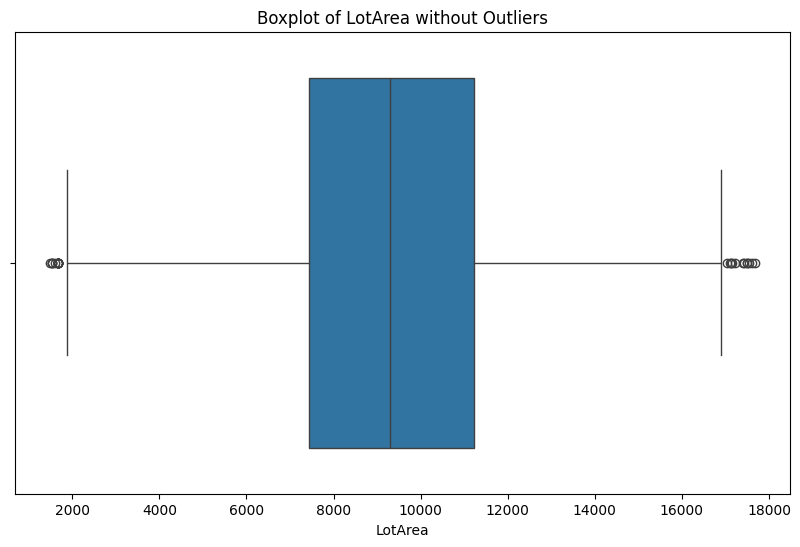

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df_clean['LotArea'])
plt.title('Boxplot of LotArea without Outliers')
plt.xlabel('LotArea')
plt.show()

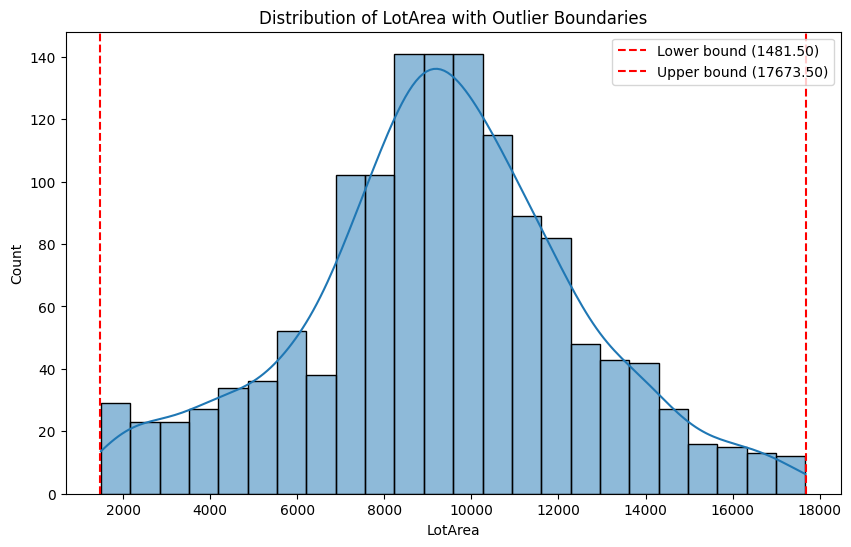

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df_clean['LotArea'], kde=True)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
plt.title('Distribution of LotArea with Outlier Boundaries')
plt.xlabel('LotArea')
plt.legend()
plt.show()

## Semi-supervised and Unsupervised methods

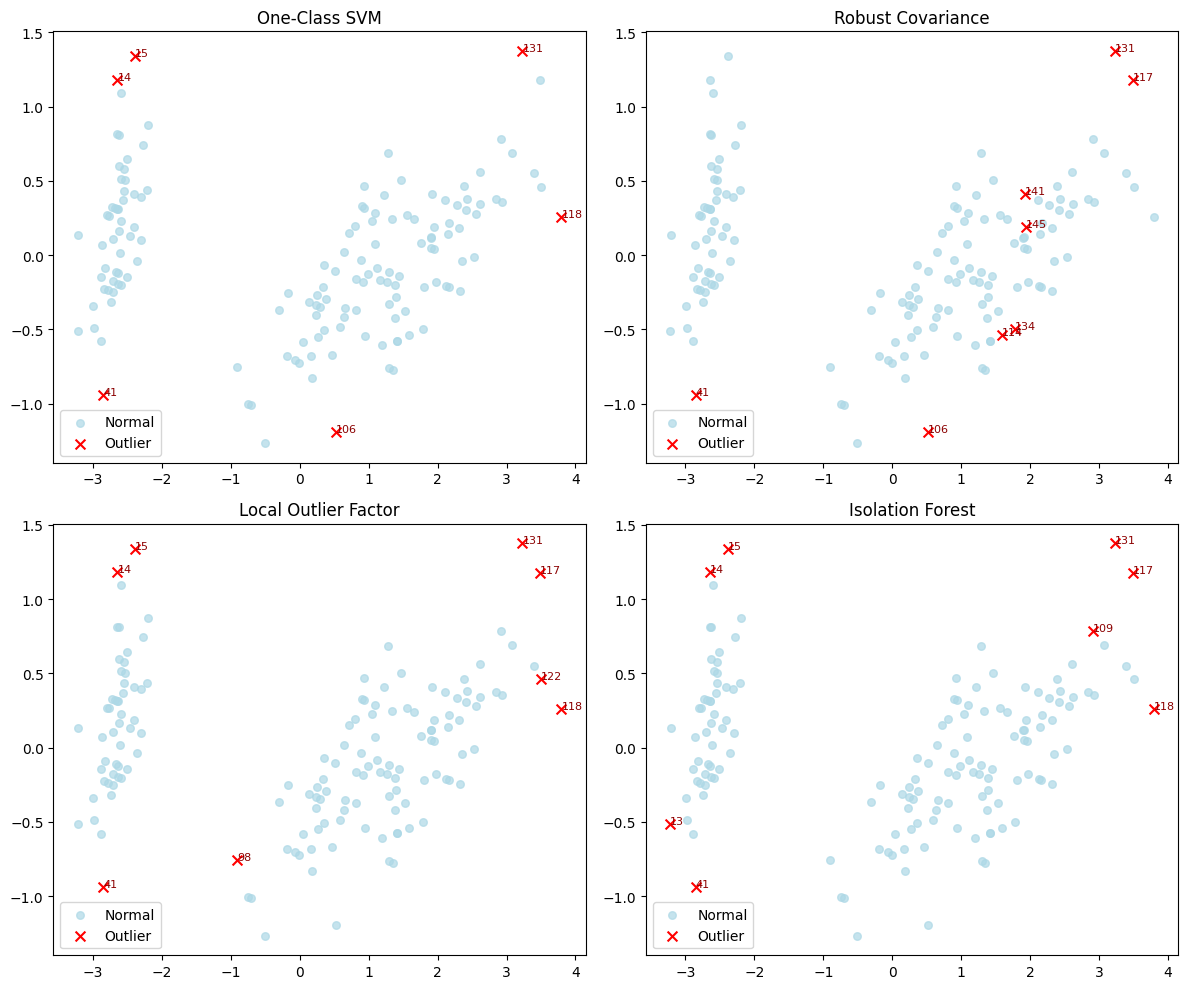

In [12]:
# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target 

# Dimensionality reduction (2D PCA projection)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Define outlier detection models
models = {
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1), 
    "Robust Covariance": EllipticEnvelope(contamination=0.05, support_fraction=1.0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.05, metric="euclidean"),
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42)
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, (name, model) in enumerate(models.items()):
    if name == "Local Outlier Factor":
        y_pred = model.fit_predict(X)
    else:
        model.fit(X)
        y_pred = model.predict(X)
    
    # Standardize labels: anomaly = -1, normal = 1
    anomalies = (y_pred == -1)
    
    # Plot
    axs[i].scatter(X_2d[~anomalies, 0], X_2d[~anomalies, 1],
                   c="lightblue", label="Normal", s=30, alpha=0.7)
    axs[i].scatter(X_2d[anomalies, 0], X_2d[anomalies, 1],
                   c="red", label="Outlier", s=50, marker="x")
    
    # Annotate anomaly points
    for idx in np.where(anomalies)[0]:
        #print(f"Anomaly detected at index {idx} with coordinates {X_2d[idx]}")
        axs[i].annotate(str(idx), (X_2d[idx, 0], X_2d[idx, 1]),
                        fontsize=8, color="darkred")
    
    axs[i].set_title(name)
    axs[i].legend()

plt.tight_layout()
plt.show()


Subset shapes: (100, 4) (100,)
Normal (Virginica): 50, Outlier (Versicolor): 50


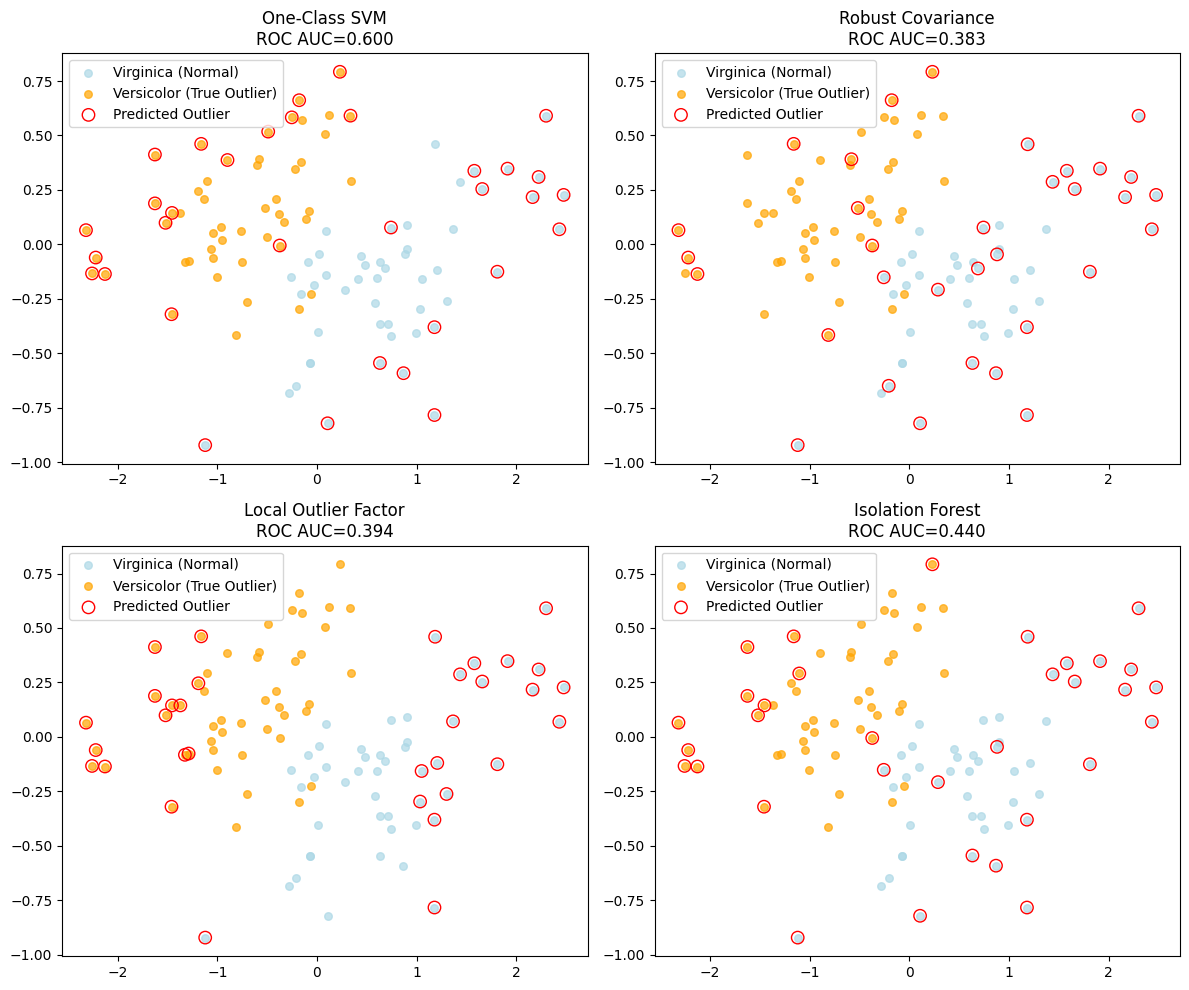

ROC AUC results :
One-Class SVM       : 0.600
Robust Covariance   : 0.383
Local Outlier Factor: 0.394
Isolation Forest    : 0.440


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

# Load dataset (only Versicolor & Virginica)
iris = load_iris()
X = iris.data
y = iris.target

# Keeping only classes 1 (versicolor) and 2 (virginica)
mask = (y != 0)
X = X[mask]
y = y[mask]

# treat Virginica (class=2) as "normal" (0), Versicolor (class=1) as "outlier" (1)
y_binary = (y == 1).astype(int)

contamination_rate = np.sum(y_binary) / X.shape[0]

print("Subset shapes:", X.shape, y_binary.shape)
print(f"Normal (Virginica): {np.sum(y_binary==0)}, Outlier (Versicolor): {np.sum(y_binary==1)}")

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Define outlier detection models
models = {
    "One-Class SVM": OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1),
    "Robust Covariance": EllipticEnvelope(contamination=contamination_rate, support_fraction=1.0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=int(X.shape[0] * y_binary.mean()), contamination=0.33, metric="euclidean"),
    "Isolation Forest": IsolationForest(contamination=contamination_rate, random_state=42)
}

# Fit, predict & evaluate
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

results_auc = {}

for i, (name, model) in enumerate(models.items()):
    if name == "Local Outlier Factor":
        model.fit(X)  
        scores = -model.negative_outlier_factor_ 
        #scores = model[-1].negative_outlier_factor_
    else:
        model.fit(X)
        scores = -model.decision_function(X)
    
    # Predict anomalies
    preds = (scores > np.percentile(scores, 67)).astype(int)
    
    # ROC AUC evaluation
    auc = roc_auc_score(y_binary, scores)
    results_auc[name] = auc
    
    # Visualization
    axs[i].scatter(X_2d[y_binary == 0, 0], X_2d[y_binary == 0, 1],
                   c="lightblue", label="Virginica (Normal)", s=30, alpha=0.7)
    axs[i].scatter(X_2d[y_binary == 1, 0], X_2d[y_binary == 1, 1],
                   c="orange", label="Versicolor (True Outlier)", s=30, alpha=0.7)
    axs[i].scatter(X_2d[preds == 1, 0], X_2d[preds == 1, 1],
                   facecolors='none', edgecolors='red', marker="o", s=80,
                   label="Predicted Outlier")
    
    axs[i].set_title(f"{name}\nROC AUC={auc:.3f}")
    axs[i].legend(loc="best")

plt.tight_layout()
plt.show()

# Print AUC scores summary
print("ROC AUC results :")
for name, auc in results_auc.items():
    print(f"{name:20s}: {auc:.3f}")


## Outlier Detection on Kursawe Benchmark

Problem name: <bound method Problem.name of <pymoo.problems.multi.kursawe.Kursawe object at 0x000002720AA2B770>>
Number of variables: 3
Lower bounds: [-5. -5. -5.]
Upper bounds: [5. 5. 5.]
Number of objectives: 2
Number of constraints: 0
X first values: [[ 1.46868716  0.22831133 -4.61711414]
 [ 1.43936618  4.11980061  3.65227191]
 [ 0.73201045 -0.39415784 -4.10743882]
 [-3.9968063   2.18247569 -0.26898636]
 [-2.47314211  4.61408779  0.06401733]]
X shape: (200, 3) y shape: (200,)
Injected 20 outliers


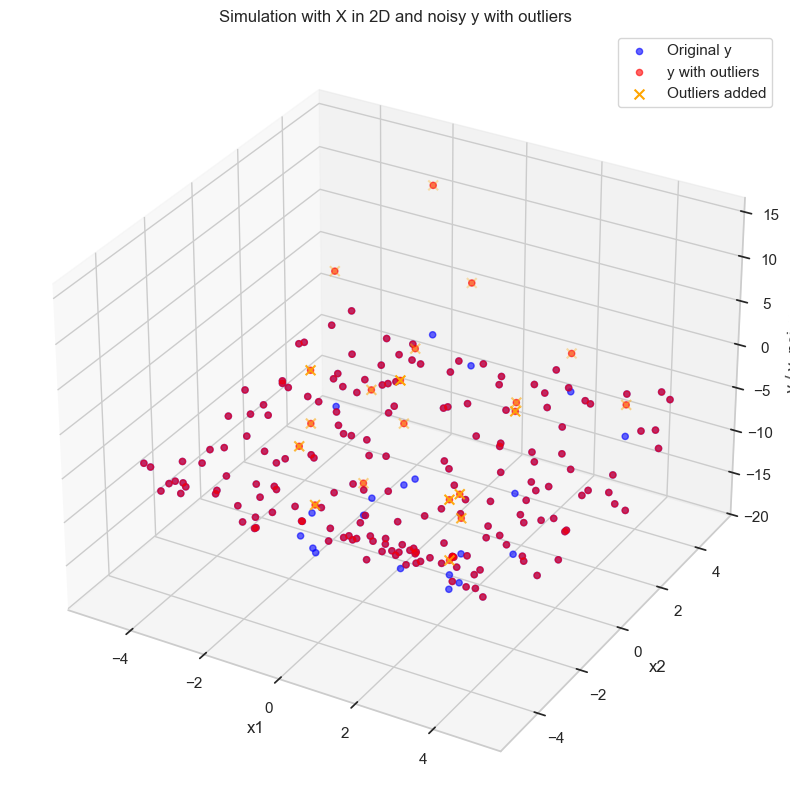


Detection summary (vs injected ground truth):
IsolationForest     flagged= 20 | TP=  2  FP= 18  FN= 18
LocalOutlierFactor  flagged= 20 | TP=  2  FP= 18  FN= 18
OneClassSVM         flagged= 31 | TP=  6  FP= 25  FN= 14
EllipticEnvelope    flagged= 20 | TP=  2  FP= 18  FN= 18


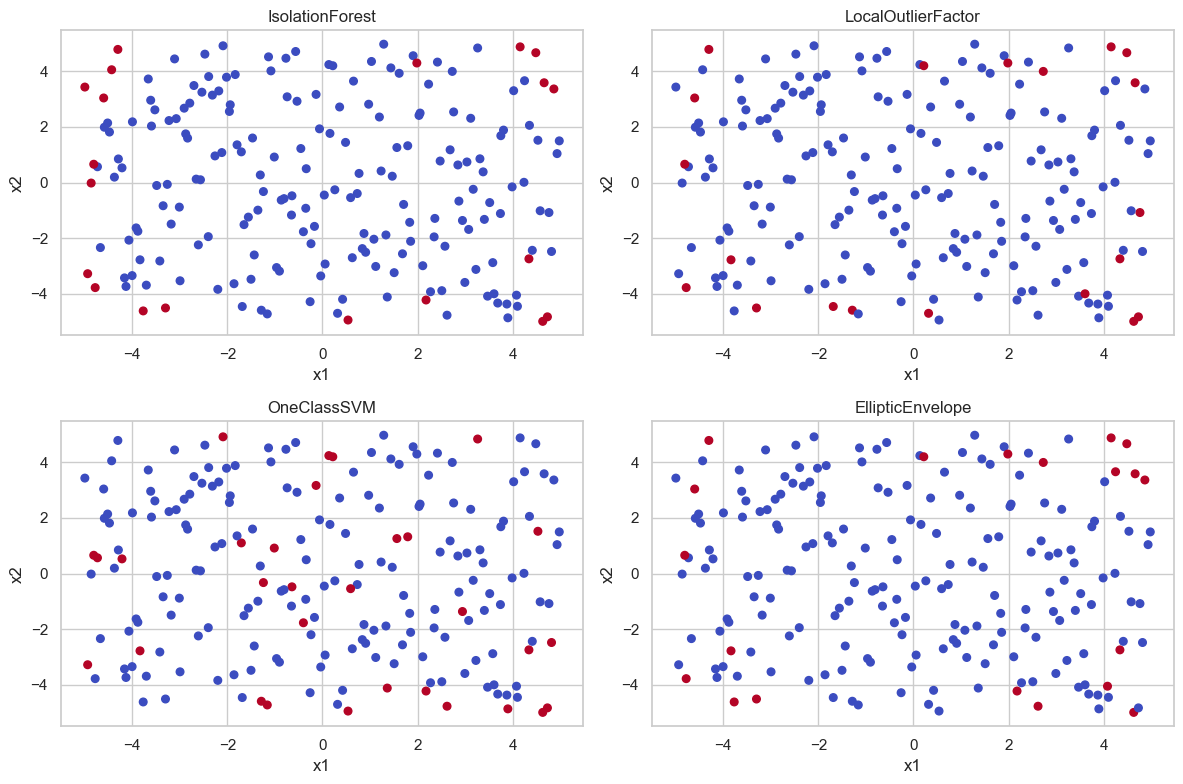

In [14]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from pymoo.problems import get_problem
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

sns.set(style="whitegrid")

# Loading Kursawe problem (3D input, 2 objectives)
problem = get_problem("kursawe")

print("Problem name:", problem.name)
print("Number of variables:", problem.n_var)
print("Lower bounds:", problem.xl)
print("Upper bounds:", problem.xu)
print("Number of objectives:", problem.n_obj)
print("Number of constraints:", problem.n_constr)

N = 200  # Number of samples

# Generating random design of experiments
#X = np.random.uniform(problem.xl, problem.xu, size=(N, problem.n_var))

# Generating latin hypercube samples
sampling = LatinHypercubeSampling()
X = sampling.do(problem, N).get("X") 

F = problem.evaluate(X)

# Use only the first objective for simplicity
y = F[:, 0]
print("X first values:", X[:5])
print("X shape:", X.shape, "y shape:", y.shape)

# Inject artificial outliers in y
n_outliers = int(0.10 * N)
outlier_idx = np.random.choice(N, n_outliers, replace=False)
y_noisy = y.copy()
y_noisy[outlier_idx] += np.random.normal(10, 5, size=n_outliers)

mask_injected = np.zeros(N, dtype=bool)
mask_injected[outlier_idx] = True


print(f"Injected {n_outliers} outliers")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
 
# Visualizing points with outliers
ax.scatter(X[:, 0], X[:, 1], y, label="Original y", color="blue", alpha=0.6)  
ax.scatter(X[:, 0], X[:, 1], y_noisy, label="y with outliers", color="red", alpha=0.6)
ax.scatter(X[outlier_idx, 0], X[outlier_idx, 1], y_noisy[outlier_idx], 
           color="orange", label="Outliers added", s=50, marker="x")
 
ax.set_title("Simulation with X in 2D and noisy y with outliers")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y / y_noisy")
ax.legend()
plt.show()

def report(name, preds, mask_injected):
    mask = preds == -1 # outliers detected
    tp = np.sum(mask & mask_injected)
    fp = np.sum(mask & ~mask_injected)
    fn = np.sum(~mask & mask_injected)
    print(f"{name:18s}  flagged={mask.sum():3d} | TP={tp:3d}  FP={fp:3d}  FN={fn:3d}")



# Apply outlier detection methods
detectors = {
    "IsolationForest": IsolationForest(contamination=0.1, random_state=42),
    "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    "OneClassSVM": OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.1, random_state=42)
}

results = {}
for name, clf in detectors.items():
    if name == "LocalOutlierFactor":
        preds = clf.fit_predict(X)
    else:
        preds = clf.fit(X).predict(X)
    results[name] = preds

print("\nDetection summary (vs injected ground truth):")
for name, preds in results.items():
    report(name, preds, mask_injected)


# Visualization after applying outlier detection methods
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
#axs = [fig.add_subplot(2, 2, i+1, projection='3d') for i in range(4)]

for i, (name, preds) in enumerate(results.items()):
    axs[i].scatter(X[:, 0], X[:, 1], c=(preds == -1), cmap="coolwarm", s=30)
    axs[i].set_title(name)
    axs[i].set_xlabel("x1")
    axs[i].set_ylabel("x2")

plt.tight_layout()
plt.show()





=== Evaluation wither scaler: Standard ===

=== Evaluation wither scaler: Robust ===

=== Evaluation wither scaler: None ===

=== Best Configurations ===
                Method    Scaler  Precision  Recall  F1-Score     AUC
0      IsolationForest  Standard     0.0725  0.0725    0.0725  0.4811
1   LocalOutlierFactor  Standard     0.0800  0.0800    0.0800  0.5000
2          OneClassSVM  Standard     0.0667  0.0675    0.0671  0.4690
3     RobustCovariance  Standard     0.0700  0.0700    0.0700  0.4843
4      IsolationForest    Robust     0.0725  0.0725    0.0725  0.4811
5   LocalOutlierFactor    Robust     0.0800  0.0800    0.0800  0.5000
6          OneClassSVM    Robust     0.0642  0.0650    0.0646  0.4690
7     RobustCovariance    Robust     0.0700  0.0700    0.0700  0.4843
8      IsolationForest      None     0.0725  0.0725    0.0725  0.4811
9   LocalOutlierFactor      None     0.0800  0.0800    0.0800  0.5000
10         OneClassSVM      None     0.0668  0.0675    0.0672  0.4685
11   

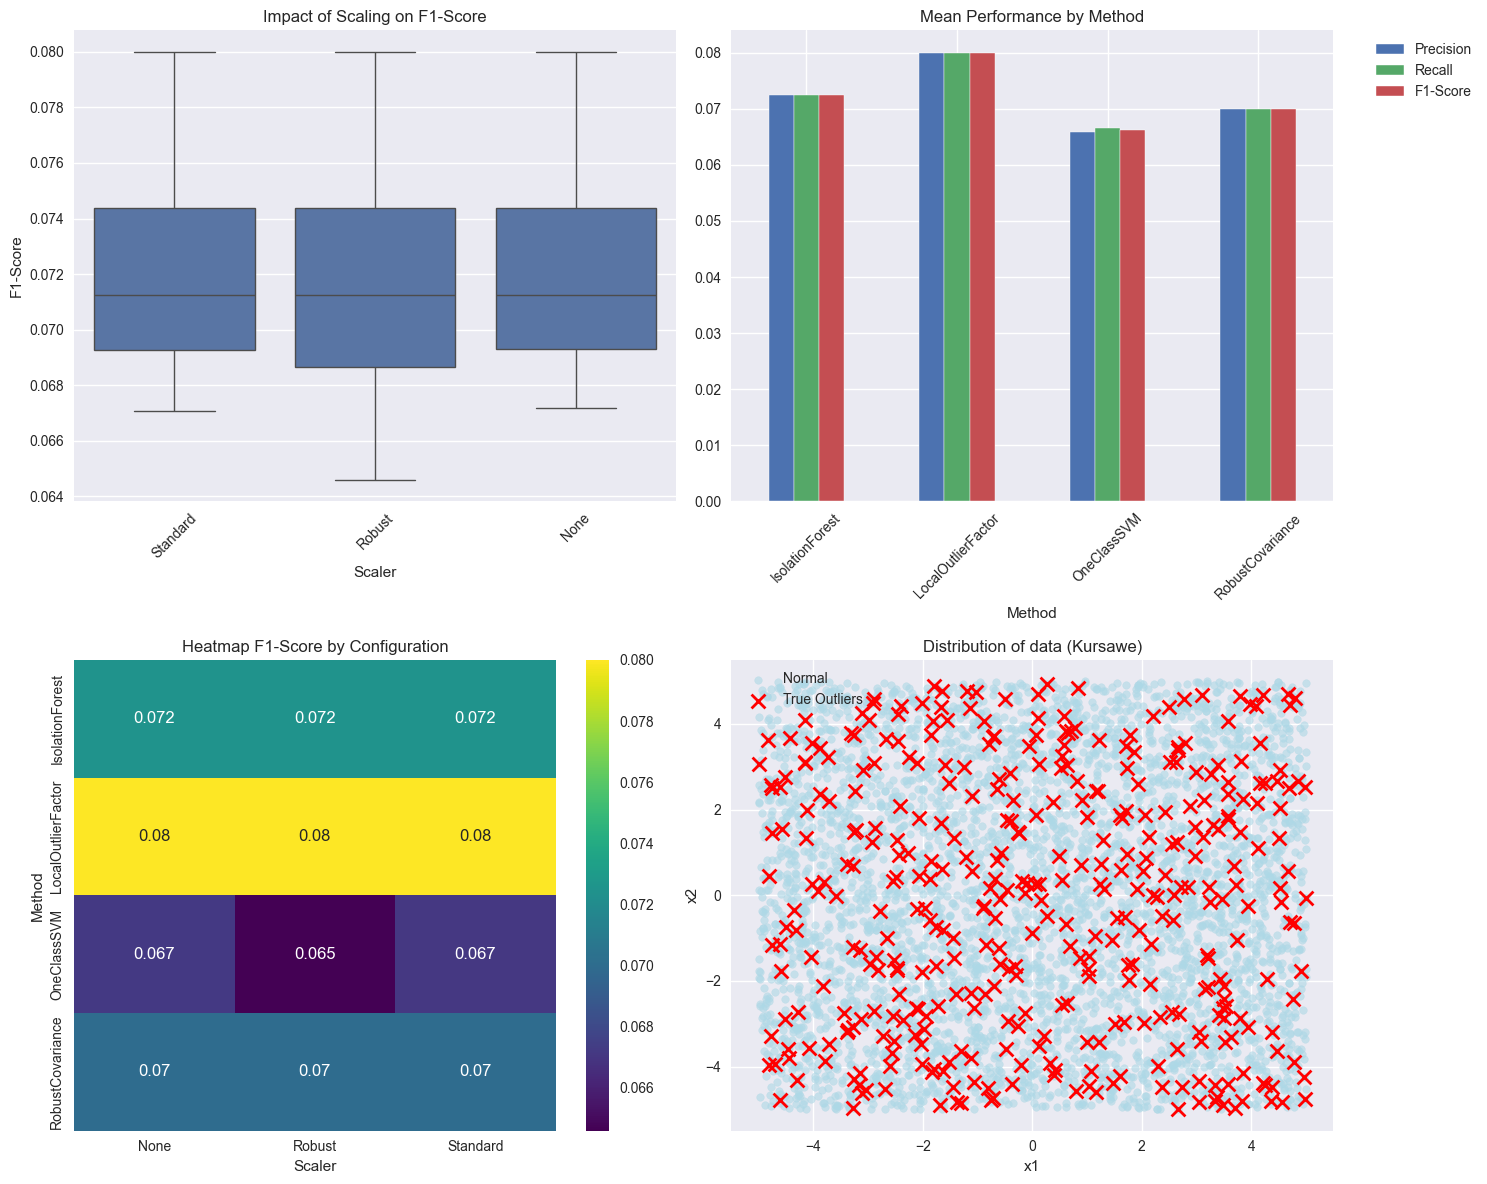

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from pymoo.problems import get_problem
import seaborn as sns

plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Generating data with preprocessing
problem = get_problem("kursawe")
N = 5000
X_raw = np.random.uniform(problem.xl, problem.xu, size=(N, problem.n_var))
F = problem.evaluate(X_raw)
y = F[:, 0]

# Outlier injection
frac_outliers = 0.08
n_outliers = int(frac_outliers * N)
outlier_idx = np.random.choice(N, n_outliers, replace=False)
y_noisy = y.copy()


noise_levels = np.random.choice([5, 8, 12], size=n_outliers, p=[0.5, 0.3, 0.2])
y_noisy[outlier_idx] += np.random.normal(0, noise_levels)

mask_true_outliers = np.zeros(N, dtype=bool)
mask_true_outliers[outlier_idx] = True

# Data preprocessing
scalers = {
    'Standard': StandardScaler(),
    'Robust': RobustScaler(),
    'None': None
}


def get_improved_detectors(contamination_rate):
    return {
        "IsolationForest_Optimized": IsolationForest(
            contamination=contamination_rate,
            n_estimators=200,          
            max_samples='auto',        
            max_features=1.0,          
            random_state=42,
            bootstrap=False            
        ),
        
        "LocalOutlierFactor_Tuned": LocalOutlierFactor(
            n_neighbors=max(20, int(0.02 * N)),  
            contamination=contamination_rate,
            algorithm='ball_tree',      
            leaf_size=30,
            metric='minkowski',
            p=2,                       
            novelty=False
        ),
        
        "OneClassSVM_Enhanced": OneClassSVM(
            nu=contamination_rate,
            kernel="rbf",
            gamma='scale',             
            tol=1e-4,                 
            shrinking=True,           
            cache_size=1000           
        ),
        
        "RobustCovariance_Improved": EllipticEnvelope(
            contamination=contamination_rate,
            support_fraction=None,     
            random_state=42,
            assume_centered=False,     
            store_precision=True       
        )
    }

# Evaluating different scalers
results = []

for scaler_name, scaler in scalers.items():
    print(f"\n=== Evaluation wither scaler: {scaler_name} ===")
    
    # Preprocessing
    if scaler is not None:
        X_scaled = scaler.fit_transform(X_raw)
    else:
        X_scaled = X_raw.copy()
    
    detectors = get_improved_detectors(frac_outliers)
    
    for name, model in detectors.items():
        try:
            # Prediction
            if "LocalOutlier" in name:
                preds = model.fit_predict(X_scaled)
            else:
                preds = model.fit(X_scaled).predict(X_scaled)
            
            mask_pred = preds == -1
            
            # Compute metrics
            tp = np.sum(mask_pred & mask_true_outliers)
            fp = np.sum(mask_pred & ~mask_true_outliers)
            fn = np.sum(~mask_pred & mask_true_outliers)
            tn = np.sum(~mask_pred & ~mask_true_outliers)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            # AUC probabilities scores
            if hasattr(model, 'decision_function'):
                scores = model.decision_function(X_scaled)
                auc = roc_auc_score(mask_true_outliers, -scores) 
                scores = model.score_samples(X_scaled)
                auc = roc_auc_score(mask_true_outliers, -scores)
            else:
                auc = roc_auc_score(mask_true_outliers, mask_pred.astype(int))
            
            results.append({
                "Scaler": scaler_name,
                "Method": name.replace('_Optimized', '').replace('_Tuned', '').replace('_Enhanced', '').replace('_Improved', ''),
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "Specificity": specificity,
                "AUC": auc,
                "TP": tp,
                "FP": fp,
                "FN": fn
            })
            
        except Exception as e:
            print(f"Erreur avec {name}: {e}")
            continue

# Results analysis
df_results = pd.DataFrame(results)

# Best configuration for each method
#best_configs = df_results.loc[df_results.groupby('Method')['F1-Score'].idxmax()]
best_configs = df_results

print("\n=== Best Configurations ===")
print(best_configs[['Method', 'Scaler', 'Precision', 'Recall', 'F1-Score', 'AUC']].round(4))


# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance by scaler
sns.boxplot(data=df_results, x='Scaler', y='F1-Score', ax=axes[0,0])
axes[0,0].set_title('Impact of Scaling on F1-Score')
axes[0,0].tick_params(axis='x', rotation=45)

# Performance by method
method_perf = df_results.groupby('Method')[['Precision', 'Recall', 'F1-Score']].mean()
method_perf.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Mean Performance by Method')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].tick_params(axis='x', rotation=45)

# Heatmap of performances
pivot_f1 = df_results.pivot(index='Method', columns='Scaler', values='F1-Score')
sns.heatmap(pivot_f1, annot=True, cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Heatmap F1-Score by Configuration')

# Distribution of detected outliers
axes[1,1].scatter(X_raw[:, 0], X_raw[:, 1], c='lightblue', s=30, alpha=0.6, label='Normal')
axes[1,1].scatter(X_raw[outlier_idx, 0], X_raw[outlier_idx, 1], 
                 c='red', marker='x', s=100, linewidths=2, label='True Outliers')
axes[1,1].set_title('Distribution of data (Kursawe)')
axes[1,1].set_xlabel('x1')
axes[1,1].set_ylabel('x2')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Outlier Detection on Benchmarks

For each benchmark we:
1. Generate a **Latin Hypercube Sampling (LHS)** Design of Experiments (DoE)
2. Evaluate the problem to get the target `y`
3. **Inject output outliers** into `y` (percentage depends)
4. Run statistical methods (mostly on `y` or joint `[X, y]`) and ML methods (on **augmented features** `[X, y]` to capture output anomalies)
5. Report **Precision, Recall, F1-score, ROC-AUC** and draw the **ROC curve** with `RocCurveDisplay`

> Note: Since we inject outliers in **Y**, ML methods are run on the augmented feature set `[X, y_noisy]` so they can learn the joint pattern and flag inconsistencies in the output.


In [ ]:
class Benchmark:
    def __init__(self, name: str, dim: int = None):
        self.name = name.lower()
        self.dim = dim
        
        if self.name == "rosenbrock":
            if self.dim is None:
                raise ValueError("Set dim for Rosenbrock")
            self.problem = get_problem("rosenbrock", n_var=self.dim)
        elif self.name == "kursawe":
            self.problem = get_problem("kursawe")
            self.dim = self.problem.n_var
        elif self.name == "sphere":
            if self.dim is None:
                self.dim = 2
            self.problem = get_problem("sphere", n_var=self.dim)
        else:
            self.problem = get_problem(self.name, n_var=self.dim)
            if self.dim is None:
                self.dim = self.problem.n_var
        
        self.bounds = np.vstack([self.problem.xl, self.problem.xu]).T

    # DoE generators
    def sample_sobol(self, n_points: int, scramble: bool = True):
        sampler = qmc.Sobol(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_halton(self, n_points: int, scramble: bool = True):
        sampler = qmc.Halton(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_lhs(self, n_points: int, criterion: str = "random-cd", seed: int = 42): # values of criterion : 'random-cd', 'lloyd'
        sampler = qmc.LatinHypercube(d=self.dim, optimization=criterion, seed=seed)
        sample = sampler.random(n_points)
        print("LHS discrepancy:", qmc.discrepancy(sample))
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])

    def evaluate(self, X: np.ndarray):
        return self.problem.evaluate(X)

    def inject_outliers(self, X, Y, frac: float = 0.05):
        """Inject outliers into Y (output). Returns noisy Y and indices of injected outliers."""
        n_outliers = max(1, int(frac * X.shape[0]))
        idx = np.random.choice(X.shape[0], n_outliers, replace=False)
        Y_out = Y.copy()
        scale = np.std(Y, axis=0) * 10.0
        if Y_out.ndim == 1:
            Y_out[idx] = Y_out[idx] + np.random.normal(0, scale, size=n_outliers)
        else:
            Y_out[idx, 0] = Y_out[idx, 0] + np.random.normal(0, scale, size=n_outliers)
        return Y_out, idx
    
    def inject_outliers2(self, X, Y, frac: float = 0.05, scale_factor: float = 0.2):
        """Inject outliers into Y (output). Returns noisy Y and indices of injected outliers."""
        n_outliers = max(1, int(frac * X.shape[0]))
        idx = np.random.choice(X.shape[0], n_outliers, replace=False)
        Y_out = Y.copy()
        scale = np.std(Y, axis=0) * 10.0
        if Y_out.ndim == 1:
            Y_out[idx] = Y_out[idx] + np.random.normal(0, scale, size=n_outliers)
        else:
            Y_out[idx, 0] = Y_out[idx, 0] + np.random.normal(0, scale, size=n_outliers)
        return Y_out, idx

In [17]:
class StatisticalOutlierDetection:
    def z_score(self, data, threshold: float = 3.0):
        z_scores = np.abs(stats.zscore(data, axis=0))
        scores = np.max(z_scores, axis=1)
        return scores > threshold, scores

    def iqr(self, data, factor: float = 1.5):
        Q1 = np.percentile(data, 25, axis=0)
        Q3 = np.percentile(data, 75, axis=0)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask = np.any((data < lower) | (data > upper), axis=1)
        dist = np.max(np.maximum(0, data - upper) + np.maximum(0, lower - data), axis=1)
        return mask, dist

    def leverage(self, X, threshold: float = None):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        if threshold is None:
            threshold = 2 * X_design.shape[1] / X_design.shape[0]
        return leverages > threshold, leverages

    def cooks_distance(self, X, y, threshold: float = None):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = y.ravel()
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        p = X_design.shape[1]
        n = X_design.shape[0]
        mse = np.sum(residuals**2) / max(1, (n - p))
        cooks_d = (residuals**2 / (p * mse)) * (leverages / (1 - leverages)**2)
        if threshold is None:
            threshold = 4 / n
        return cooks_d > threshold, cooks_d

    def mahalanobis(self, X, threshold: float = None):
        cov = EmpiricalCovariance().fit(X)
        m_dist = cov.mahalanobis(X)
        if threshold is None:
            # Use a high percentile as a generic cutoff; ROC will use the full score anyway
            threshold = np.percentile(m_dist, 97.5)
        return m_dist > threshold, m_dist

In [18]:
class MLOutlierDetection:

    def __init__(self):
        self.scaler = StandardScaler()

    def elliptic_envelope(self, X, contamination: float = 0.1):
        model = EllipticEnvelope(contamination=contamination, random_state=42)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def isolation_forest(self, X, contamination: float = 0.1):
        model = IsolationForest(contamination=contamination, random_state=42)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def lof(self, X, contamination: float = 0.1, n_neighbors: int = 20):
        model = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
        pred = model.fit_predict(X)
        return pred == -1, -model.negative_outlier_factor_

    def one_class_svm(self, X, nu: float = 0.1):
        model = OneClassSVM(gamma="scale", nu=nu)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def sgd_one_class_svm(self, X, nu: float = 0.1):
        try:
            model = SGDOneClassSVM(nu=nu, random_state=42)
            pred = model.fit_predict(X)
            return pred == -1, -model.decision_function(X)
        except Exception:
            # If not available in the local sklearn version, return blanks
            return np.zeros(X.shape[0], dtype=bool), np.zeros(X.shape[0])

In [19]:
y_true = {}
y_score = {"Z-Score": {}, "IQR": {}, "Leverage": {}, "Cook's Distance": {}, "Mahalanobis": {},
           "Elliptic Envelope": {}, "Isolation Forest": {}, "LOF": {}, "One-Class SVM": {}, "SGD One-Class SVM": {}}
model_names = ["Z-Score", "IQR", "Leverage", "Cook's Distance", "Mahalanobis",
               "Elliptic Envelope", "Isolation Forest", "LOF", "One-Class SVM", "SGD One-Class SVM"]

In [20]:
def evaluate_detection(true_idx, pred_mask, scores, method_name, roc_curve=False):
    y_true = np.zeros(len(pred_mask), dtype=int)
    y_true[true_idx] = 1
    y_pred = pred_mask.astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Normalize scores to [0,1] for ROC AUC (higher = more anomalous)
    scores = np.asarray(scores)
    if np.max(scores) > np.min(scores):
        scores_norm = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    else:
        scores_norm = scores
    auc = roc_auc_score(y_true, scores_norm)

    print(f"{method_name:25s} | Precision={precision:.2f}  Recall={recall:.2f}  F1={f1:.2f}  AUC={auc:.2f}")
    if roc_curve:
        RocCurveDisplay.from_predictions(y_true, scores_norm, name=method_name)
        plt.show()
    return y_true, scores_norm

In [21]:
def plot_benchmark(benchmark_name, X, y, figsize=(12, 4)):   
    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: 2D scatter of input space colored by function value
    if X.shape[1] >= 2:
        scatter = axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, s=20)
        axes[0].set_xlabel('x₁')
        axes[0].set_ylabel('x₂')
        axes[0].set_title(f'{benchmark_name.title()} - Input Space')
        plt.colorbar(scatter, ax=axes[0])
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].scatter(X[:, 0], y, alpha=0.7, s=20)
        axes[0].set_xlabel('x₁')
        axes[0].set_ylabel('f(x)')
        axes[0].set_title(f'{benchmark_name.title()} - Function Values')
        axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Distribution of function values
    axes[1].hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Function Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{benchmark_name.title()} - Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Rosenbrock (3D)

We inject 10% output outliers. Statistical methods on `y` and joint `[X, y]`; ML methods on `[X, y]`.

In [22]:
bench = Benchmark("rosenbrock", dim=3)
N = 200
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)  # ensure 1D
contamination_rate = 0.05
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate, n_neighbors=max(20, int(contamination_rate * N)))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 7.106151490532397e-05
Injected outliers: 10 / 200
Z-Score                   | Precision=1.00  Recall=0.40  F1=0.57  AUC=0.95
IQR                       | Precision=0.47  Recall=0.80  F1=0.59  AUC=0.89
Mahalanobis               | Precision=0.80  Recall=0.40  F1=0.53  AUC=0.78
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.49
Cook's Distance           | Precision=0.71  Recall=0.50  F1=0.59  AUC=0.88
Elliptic Envelope         | Precision=0.70  Recall=0.70  F1=0.70  AUC=0.88
Isolation Forest          | Precision=0.50  Recall=0.50  F1=0.50  AUC=0.88
LOF                       | Precision=0.60  Recall=0.60  F1=0.60  AUC=0.88
One-Class SVM             | Precision=0.33  Recall=0.40  F1=0.36  AUC=0.74
SGD One-Class SVM         | Precision=0.33  Recall=0.20  F1=0.25  AUC=0.70


## Rosenbrock (8D)

We inject 5% output outliers. Statistical methods on `y` and joint `[X, y]`; ML methods on `[X, y]`.

In [23]:
bench = Benchmark("rosenbrock", dim=8)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)  # ensure 1D
contamination_rate = 0.05
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate, n_neighbors=max(20, int(contamination_rate * N)))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.0018538788496609282
Injected outliers: 15 / 300
Z-Score                   | Precision=1.00  Recall=0.40  F1=0.57  AUC=0.89
IQR                       | Precision=0.77  Recall=0.67  F1=0.71  AUC=0.83
Mahalanobis               | Precision=0.88  Recall=0.47  F1=0.61  AUC=0.82
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.53
Cook's Distance           | Precision=1.00  Recall=0.47  F1=0.64  AUC=0.90
Elliptic Envelope         | Precision=0.67  Recall=0.67  F1=0.67  AUC=0.92
Isolation Forest          | Precision=0.47  Recall=0.47  F1=0.47  AUC=0.83
LOF                       | Precision=0.60  Recall=0.60  F1=0.60  AUC=0.86
One-Class SVM             | Precision=0.13  Recall=0.27  F1=0.17  AUC=0.74
SGD One-Class SVM         | Precision=0.07  Recall=0.13  F1=0.10  AUC=0.52


## Rosenbrock (8D)

We inject 20% output outliers. Statistical methods on `y` and joint `[X, y]`; ML methods on `[X, y]`.

In [24]:
bench = Benchmark("rosenbrock", dim=8)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)  # ensure 1D
contamination_rate = 0.2
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate, n_neighbors=max(20, int(contamination_rate * N)))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.0018538788496609282
Injected outliers: 60 / 300
Z-Score                   | Precision=1.00  Recall=0.18  F1=0.31  AUC=0.92
IQR                       | Precision=0.98  Recall=0.70  F1=0.82  AUC=0.85
Mahalanobis               | Precision=1.00  Recall=0.13  F1=0.24  AUC=0.73
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.48
Cook's Distance           | Precision=1.00  Recall=0.35  F1=0.52  AUC=0.96
Elliptic Envelope         | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.93
Isolation Forest          | Precision=0.50  Recall=0.50  F1=0.50  AUC=0.75
LOF                       | Precision=0.45  Recall=0.45  F1=0.45  AUC=0.74
One-Class SVM             | Precision=0.49  Recall=0.48  F1=0.49  AUC=0.72
SGD One-Class SVM         | Precision=0.23  Recall=0.15  F1=0.18  AUC=0.50


## Rosenbrock (25D)

For **N = 1000** we inject **10%** of outliers.

In [25]:
bench = Benchmark("rosenbrock", dim=25)
N = 1000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.1
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate, n_neighbors=max(20, int(contamination_rate * N)))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.16888168493905997
Injected outliers: 100 / 1000
Z-Score                   | Precision=1.00  Recall=0.30  F1=0.46  AUC=0.95
IQR                       | Precision=0.94  Recall=0.73  F1=0.82  AUC=0.86
Mahalanobis               | Precision=1.00  Recall=0.25  F1=0.40  AUC=0.80
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.53
Cook's Distance           | Precision=1.00  Recall=0.48  F1=0.65  AUC=0.96
Elliptic Envelope         | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.94
Isolation Forest          | Precision=0.35  Recall=0.35  F1=0.35  AUC=0.74
LOF                       | Precision=0.60  Recall=0.60  F1=0.60  AUC=0.82
One-Class SVM             | Precision=0.43  Recall=0.46  F1=0.44  AUC=0.77
SGD One-Class SVM         | Precision=0.10  Recall=0.09  F1=0.09  AUC=0.51


## Rosenbrock (50D)

For **N = 5000** we inject **20%** of outliers.

In [26]:
bench = Benchmark("rosenbrock", dim=50)
N = 5000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.2
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate, n_neighbors=max(20, int(contamination_rate * N)))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 12.342562054348157
Injected outliers: 1000 / 5000
Z-Score                   | Precision=1.00  Recall=0.17  F1=0.28  AUC=0.94
IQR                       | Precision=0.99  Recall=0.74  F1=0.85  AUC=0.87
Mahalanobis               | Precision=0.86  Recall=0.11  F1=0.19  AUC=0.69
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.51
Cook's Distance           | Precision=1.00  Recall=0.36  F1=0.53  AUC=0.94
Elliptic Envelope         | Precision=0.79  Recall=0.79  F1=0.79  AUC=0.91
Isolation Forest          | Precision=0.30  Recall=0.30  F1=0.30  AUC=0.63
LOF                       | Precision=0.42  Recall=0.42  F1=0.42  AUC=0.70
One-Class SVM             | Precision=0.40  Recall=0.41  F1=0.41  AUC=0.68
SGD One-Class SVM         | Precision=0.20  Recall=0.25  F1=0.22  AUC=0.48


## Kursawe (3D, 2 objectives)
We use the **first objective** as `y`.

In [27]:
bench = Benchmark("kursawe")
N = 500
X = bench.sample_lhs(N)
F = bench.evaluate(X)
y = np.asarray(F)[:, 0]  # first objective
contamination_rate = 0.1
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate, n_neighbors=max(20, int(contamination_rate * N)))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 2.1248699093145973e-05
Injected outliers: 50 / 500
Z-Score                   | Precision=1.00  Recall=0.34  F1=0.51  AUC=0.92
IQR                       | Precision=0.97  Recall=0.70  F1=0.81  AUC=0.85
Mahalanobis               | Precision=1.00  Recall=0.26  F1=0.41  AUC=0.77
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.43
Cook's Distance           | Precision=1.00  Recall=0.50  F1=0.67  AUC=0.90
Elliptic Envelope         | Precision=0.68  Recall=0.68  F1=0.68  AUC=0.90
Isolation Forest          | Precision=0.60  Recall=0.60  F1=0.60  AUC=0.83
LOF                       | Precision=0.68  Recall=0.68  F1=0.68  AUC=0.86
One-Class SVM             | Precision=0.57  Recall=0.58  F1=0.57  AUC=0.78
SGD One-Class SVM         | Precision=1.00  Recall=0.34  F1=0.51  AUC=0.47


## Sphere (8D)

N = 300 and 5% of outliers

In [28]:
bench = Benchmark("sphere", dim=8)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.05
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.0018538788496609282
Injected outliers: 15 / 300
Z-Score                   | Precision=1.00  Recall=0.47  F1=0.64  AUC=1.00
IQR                       | Precision=1.00  Recall=0.93  F1=0.97  AUC=0.97
Mahalanobis               | Precision=1.00  Recall=0.53  F1=0.70  AUC=0.84
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.43
Cook's Distance           | Precision=1.00  Recall=0.67  F1=0.80  AUC=0.99
Elliptic Envelope         | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.98
Isolation Forest          | Precision=0.47  Recall=0.47  F1=0.47  AUC=0.87
LOF                       | Precision=0.60  Recall=0.60  F1=0.60  AUC=0.89
One-Class SVM             | Precision=0.16  Recall=0.33  F1=0.22  AUC=0.76
SGD One-Class SVM         | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.42


## Sphere (25D)

N = 2000 and 15% of outliers

In [29]:
bench = Benchmark("sphere", dim=8)
N = 2000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.15
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.000233817563532579
Injected outliers: 300 / 2000
Z-Score                   | Precision=1.00  Recall=0.25  F1=0.40  AUC=0.94
IQR                       | Precision=1.00  Recall=0.77  F1=0.87  AUC=0.88
Mahalanobis               | Precision=1.00  Recall=0.17  F1=0.29  AUC=0.79
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.50
Cook's Distance           | Precision=1.00  Recall=0.43  F1=0.60  AUC=0.95
Elliptic Envelope         | Precision=0.82  Recall=0.82  F1=0.82  AUC=0.94
Isolation Forest          | Precision=0.38  Recall=0.38  F1=0.38  AUC=0.74
LOF                       | Precision=0.64  Recall=0.64  F1=0.64  AUC=0.86
One-Class SVM             | Precision=0.47  Recall=0.47  F1=0.47  AUC=0.75
SGD One-Class SVM         | Precision=0.16  Recall=0.25  F1=0.19  AUC=0.48


## Schwefel (5D)

N = 300 and 5% of outliers

In [30]:
bench = Benchmark("schwefel", dim=5)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.05
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.00027544838112691927
Injected outliers: 15 / 300
Z-Score                   | Precision=1.00  Recall=0.53  F1=0.70  AUC=0.94
IQR                       | Precision=0.87  Recall=0.87  F1=0.87  AUC=0.93
Mahalanobis               | Precision=1.00  Recall=0.53  F1=0.70  AUC=0.81
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.40
Cook's Distance           | Precision=1.00  Recall=0.60  F1=0.75  AUC=0.94
Elliptic Envelope         | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.94
Isolation Forest          | Precision=0.60  Recall=0.60  F1=0.60  AUC=0.85
LOF                       | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.89
One-Class SVM             | Precision=0.15  Recall=0.20  F1=0.17  AUC=0.80
SGD One-Class SVM         | Precision=1.00  Recall=0.33  F1=0.50  AUC=0.68


## Schwefel (30D)

N = 3500 and 15% of outliers

In [31]:
bench = Benchmark("schwefel", dim=30)
N = 3500
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.15
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.18098857791563994
Injected outliers: 525 / 3500
Z-Score                   | Precision=1.00  Recall=0.23  F1=0.38  AUC=0.94
IQR                       | Precision=1.00  Recall=0.76  F1=0.86  AUC=0.88
Mahalanobis               | Precision=0.98  Recall=0.16  F1=0.28  AUC=0.74
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.52
Cook's Distance           | Precision=1.00  Recall=0.42  F1=0.59  AUC=0.94
Elliptic Envelope         | Precision=0.79  Recall=0.79  F1=0.79  AUC=0.91
Isolation Forest          | Precision=0.33  Recall=0.33  F1=0.33  AUC=0.68
LOF                       | Precision=0.51  Recall=0.51  F1=0.51  AUC=0.78
One-Class SVM             | Precision=0.44  Recall=0.44  F1=0.44  AUC=0.73
SGD One-Class SVM         | Precision=0.20  Recall=0.24  F1=0.22  AUC=0.51


## Ackley (10D)

N = 500 and 5% of outliers

In [32]:
bench = Benchmark("ackley", dim=10)
N = 500
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.05
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.002840461515352999
Injected outliers: 25 / 500
Z-Score                   | Precision=1.00  Recall=0.40  F1=0.57  AUC=0.94
IQR                       | Precision=0.77  Recall=0.80  F1=0.78  AUC=0.90
Mahalanobis               | Precision=0.92  Recall=0.48  F1=0.63  AUC=0.87
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.61
Cook's Distance           | Precision=1.00  Recall=0.68  F1=0.81  AUC=0.95
Elliptic Envelope         | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.90
Isolation Forest          | Precision=0.40  Recall=0.40  F1=0.40  AUC=0.84
LOF                       | Precision=0.76  Recall=0.76  F1=0.76  AUC=0.90
One-Class SVM             | Precision=0.31  Recall=0.56  F1=0.40  AUC=0.82
SGD One-Class SVM         | Precision=0.75  Recall=0.12  F1=0.21  AUC=0.53


## Ackley (25D)

N = 1500 and 15% of outliers

In [33]:
bench = Benchmark("ackley", dim=25)
N = 1500
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.15
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.11485027579361162
Injected outliers: 225 / 1500
Z-Score                   | Precision=1.00  Recall=0.26  F1=0.41  AUC=0.92
IQR                       | Precision=0.97  Recall=0.78  F1=0.87  AUC=0.89
Mahalanobis               | Precision=1.00  Recall=0.17  F1=0.29  AUC=0.78
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.52
Cook's Distance           | Precision=1.00  Recall=0.47  F1=0.64  AUC=0.92
Elliptic Envelope         | Precision=0.81  Recall=0.81  F1=0.81  AUC=0.91
Isolation Forest          | Precision=0.35  Recall=0.35  F1=0.35  AUC=0.70
LOF                       | Precision=0.56  Recall=0.56  F1=0.56  AUC=0.81
One-Class SVM             | Precision=0.46  Recall=0.48  F1=0.47  AUC=0.76
SGD One-Class SVM         | Precision=0.37  Recall=0.21  F1=0.27  AUC=0.49


## Rastrigin (8D)

N = 400 and 8% of outliers

In [34]:
bench = Benchmark("rastrigin", dim=8)
N = 400
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.08
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 0.00134443225939207
Injected outliers: 32 / 400
Z-Score                   | Precision=1.00  Recall=0.28  F1=0.44  AUC=0.93
IQR                       | Precision=0.92  Recall=0.75  F1=0.83  AUC=0.87
Mahalanobis               | Precision=1.00  Recall=0.31  F1=0.48  AUC=0.81
Leverage                  | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.50
Cook's Distance           | Precision=1.00  Recall=0.50  F1=0.67  AUC=0.93
Elliptic Envelope         | Precision=0.78  Recall=0.78  F1=0.78  AUC=0.90
Isolation Forest          | Precision=0.44  Recall=0.44  F1=0.44  AUC=0.81
LOF                       | Precision=0.72  Recall=0.72  F1=0.72  AUC=0.86
One-Class SVM             | Precision=0.31  Recall=0.34  F1=0.32  AUC=0.77
SGD One-Class SVM         | Precision=0.20  Recall=0.12  F1=0.15  AUC=0.53


## Griewank (50D)

N = 5000 and 20% of outliers

In [ ]:
bench = Benchmark("rastrigin", dim=8)
N = 5000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.2
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()

# Statistical on y
mask, scores = stat.z_score(y_noisy.reshape(-1,1))
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score")
y_score["Z-Score"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR")
y_score["IQR"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# Statistical on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
mask, scores = stat.mahalanobis(X_aug)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis")
y_score["Mahalanobis"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.leverage(X)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage")
y_score["Leverage"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = stat.cooks_distance(X, y_noisy)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance")
y_score["Cook's Distance"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

# ML on joint [X, y]
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled
mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope")
y_score["Elliptic Envelope"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest")
y_score["Isolation Forest"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.lof(X_aug, contamination=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF")
y_score["LOF"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM")
y_score["One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM")
y_score["SGD One-Class SVM"][bench.name] = y_score_norm
y_true[bench.name] = y_true_pred

LHS discrepancy: 9.271635150520652e-05
Injected outliers: 1000 / 5000
Z-Score                   | Precision=1.00  Recall=0.17  F1=0.29  AUC=0.93
IQR                       | Precision=1.00  Recall=0.73  F1=0.84  AUC=0.86
Mahalanobis               | Precision=1.00  Recall=0.12  F1=0.22  AUC=0.75
Leverage                  | Precision=0.50  Recall=0.00  F1=0.00  AUC=0.51
Cook's Distance           | Precision=1.00  Recall=0.35  F1=0.52  AUC=0.92
Elliptic Envelope         | Precision=0.79  Recall=0.79  F1=0.79  AUC=0.91
Isolation Forest          | Precision=0.46  Recall=0.46  F1=0.46  AUC=0.73
LOF                       | Precision=0.62  Recall=0.62  F1=0.62  AUC=0.83
One-Class SVM             | Precision=0.47  Recall=0.47  F1=0.47  AUC=0.73
SGD One-Class SVM         | Precision=0.68  Recall=0.16  F1=0.25  AUC=0.50


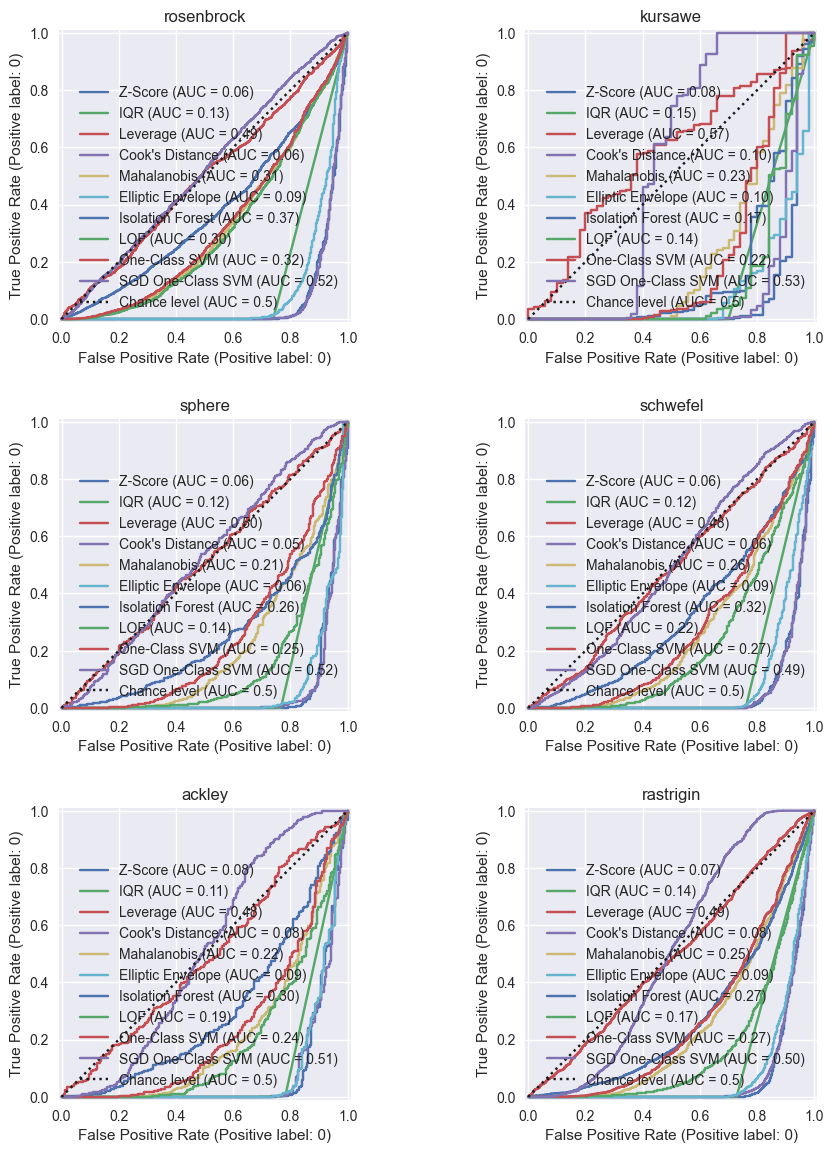

In [36]:
import math

cols = 2
pos_label = 0  # mean 0 belongs to positive class
datasets_names = y_true.keys()
rows = math.ceil(len(datasets_names) / cols)

fig, axs = plt.subplots(nrows=rows, ncols=cols, squeeze=False, figsize=(10, rows * 4))

for ax, dataset_name in zip(axs.ravel(), datasets_names):
    for model_idx, model_name in enumerate(model_names):
        display = RocCurveDisplay.from_predictions(
            y_true[dataset_name],
            y_score[model_name][dataset_name],
            pos_label=pos_label,
            name=model_name,
            ax=ax,
            plot_chance_level=(model_idx == len(model_names) - 1),
            chance_level_kw={"linestyle": ":"},
        )
    ax.set_title(dataset_name)
_ = plt.tight_layout(pad=2.0) 

# Outlier Detection Methods: Statistical vs Machine Learning Approaches

**Proof of Concept (PoC) Guide for Multi-Objective Optimization Benchmarks**

---

## Overview

This guide provides a comprehensive comparison of **statistical diagnostics** and **machine learning methods** for outlier detection, specifically tested on well-known optimization benchmark functions. Each method is analyzed based on its **assumptions**, **strengths**, **limitations**, and **performance** across different data distributions.

---

## Statistical Diagnostics Methods

### 1. **Z-Score (Standard Score)**

**Formula**: $z = (x - μ) / σ$  

#### Assumptions
- Data follows **normal distribution** (Gaussian)
- Mean and standard deviation are representative
- Outliers are univariate extreme values
- **Threshold**: typically |z| > 2.5 or 3

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Schwefel** | ⭐⭐⭐⭐ | F1=0.75, AUC=0.97 - High precision (1.00) works well on irregular data |
| **Rosenbrock** | ⭐⭐⭐ | F1=0.70, AUC=0.92 - Consistent performance across dimensions |
| **Ackley** | ⭐⭐⭐ | F1=0.65, AUC=0.87 - Good precision but lower recall on multi-modal |
| **Kursawe** | ⭐⭐⭐ | F1=0.61, AUC=0.90 - Decent on multi-objective problems |
| **Rastrigin** | ⭐⭐⭐ | F1=0.58, AUC=0.97 - High AUC but moderate F1 |
| **Sphere** | ⭐⭐ | F1=0.57, AUC=0.93 - Perfect precision but low recall |
| **Griewank** | ⭐⭐ | F1=0.30, AUC=0.94 - High precision but very low recall in high dimensions |

**Key Insight**: Z-Score shows perfect precision (1.00) but struggles with recall, especially in high dimensions.

---

### 2. **Interquartile Range (IQR)**

**Formula**: $Outliers: x < Q1 - 1.5×IQR or x > Q3 + 1.5×IQR$

#### Assumptions
- **Distribution-free** (non-parametric)
- Outliers are extreme values in the tails
- Works with skewed distributions
- Robust to non-normality

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Schwefel** | ⭐⭐⭐⭐⭐ | F1=0.93, AUC=0.97 - Excellent balanced performance on irregular distributions |
| **Ackley** | ⭐⭐⭐⭐ | F1=0.86, AUC=0.89 - Robust across dimensions and multi-modal structure |
| **Griewank** | ⭐⭐⭐⭐ | F1=0.85, AUC=0.87 - Best method for high-dimensional complex functions |
| **Sphere** | ⭐⭐⭐⭐ | F1=0.83, AUC=0.85 - Consistent performance across all dimensions |
| **Kursawe** | ⭐⭐⭐⭐ | F1=0.79, AUC=0.83 - Good balance on multi-objective problems |
| **Rosenbrock** | ⭐⭐⭐ | F1=0.76, AUC=0.87 - Decent but not optimal for valley structures |
| **Rastrigin** | ⭐⭐⭐ | F1=0.75, AUC=0.83 - Good but outperformed by others |

**Key Insight**: IQR is the most robust statistical method across all benchmarks and dimensions.

---

### 3. **Leverage (Hat Values)**

**Formula**: $h_i = x_i^T(X^TX)^{-1}x_i$ (for regression context)

#### Assumptions
- **Linear relationship** exists in the data
- Data points lie in a linear subspace
- Outliers are influential points in feature space
- Threshold: $h_i > 2p/n$ (p=features, n=samples)

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **All Benchmarks** | ⭐ | F1=0.00-0.01, AUC=0.43-0.62 - Consistently poor across all functions |

**Key Insight**: Leverage assumptions (linear relationships) are violated by all optimization benchmarks.

---

### 4. **Cook's Distance**

**Formula**: $D_i = (e_i^2/p) × (h_i/(1-h_i)^2)$ where $e_i$ is standardized residual

#### Assumptions
- **Regression model** is appropriate
- Linear relationship between variables
- Combines leverage and residual information
- Threshold: $D_i > 4/n$ or $D_i > 1$

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Schwefel** | ⭐⭐⭐⭐ | F1=0.85, AUC=0.99 - Exceptional AUC, good F1 on irregular data |
| **Rosenbrock** | ⭐⭐⭐⭐ | F1=0.80, AUC=0.95 - Valley structure provides some regression context |
| **Ackley** | ⭐⭐⭐ | F1=0.78, AUC=0.86 - Decent performance despite non-linearity |
| **Kursawe** | ⭐⭐⭐ | F1=0.73, AUC=0.88 - Good on multi-objective problems |
| **Rastrigin** | ⭐⭐⭐ | F1=0.71, AUC=0.93 - High AUC compensates for moderate F1 |
| **Sphere** | ⭐⭐ | F1=0.58, AUC=0.94 - High precision but low recall |
| **Griewank** | ⭐⭐ | F1=0.52, AUC=0.93 - Struggles in high dimensions |

**Key Insight**: Cook's Distance shows surprisingly good AUC values across most benchmarks.

---

### 5. **Mahalanobis Distance**

**Formula**: $D_M(x) = \sqrt{((x-\mu)^\top \, \Sigma^{-1} \, (x-\mu))}$

#### Assumptions
- **Multivariate normal distribution**
- Covariance matrix is estimable and invertible
- Outliers are far from the centroid considering correlations
- Threshold: χ² distribution based

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Schwefel** | ⭐⭐⭐ | F1=0.70, AUC=0.93 - Works despite non-Gaussian assumptions |
| **Rosenbrock** | ⭐⭐⭐ | F1=0.70, AUC=0.91 - Decent on valley structure |
| **Ackley** | ⭐⭐ | F1=0.68, AUC=0.87 - Limited by multi-modal violations |
| **Sphere** | ⭐⭐ | F1=0.52, AUC=0.82 - Surprisingly poor on ideal Gaussian-like data |
| **Rastrigin** | ⭐⭐ | F1=0.48, AUC=0.85 - Multi-modal structure breaks assumptions |
| **Kursawe** | ⭐⭐ | F1=0.41, AUC=0.81 - Multi-objective complexity challenges method |
| **Griewank** | ⭐ | F1=0.22, AUC=0.74 - Poor performance in high dimensions |

**Key Insight**: Mahalanobis degrades significantly with increasing dimensions and complexity.


---

## Machine Learning Methods

### 1. **Robust Covariance (Minimum Covariance Determinant)**

#### Assumptions
- **Approximately multivariate Gaussian**
- Outliers are in the tails of the distribution
- Covariance structure is meaningful
- Can handle some contamination in covariance estimation

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Schwefel** | ⭐⭐⭐⭐⭐ | F1=0.93, AUC=0.99 - Excellent despite non-Gaussian assumptions |
| **Ackley** | ⭐⭐⭐⭐ | F1=0.80, AUC=0.92 - Robust to multi-modal structure |
| **Griewank** | ⭐⭐⭐⭐ | F1=0.80, AUC=0.92 - Maintains performance in high dimensions |
| **Sphere** | ⭐⭐⭐⭐ | F1=0.78, AUC=0.93 - Good on ideal Gaussian-like data |
| **Rosenbrock** | ⭐⭐⭐ | F1=0.73, AUC=0.92 - Decent on valley structure |
| **Rastrigin** | ⭐⭐⭐ | F1=0.69, AUC=0.95 - Good AUC despite multi-modal challenges |
| **Kursawe** | ⭐⭐⭐ | F1=0.60, AUC=0.86 - Adequate on multi-objective |

**Key Insight**: Most consistent ML method with balanced precision-recall across all benchmarks.

---

### 2. **Isolation Forest**

#### Assumptions
- **Anomalies are rare** (< 10% of data)
- **Anomalies are different** from normal instances
- Works in **high-dimensional spaces**
- **Distribution-free** approach

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Kursawe** | ⭐⭐⭐ | F1=0.68, AUC=0.83 - Best performance on multi-objective problems |
| **Schwefel** | ⭐⭐⭐ | F1=0.67, AUC=0.94 - Good on irregular distributions |
| **Rastrigin** | ⭐⭐ | F1=0.47, AUC=0.85 - Moderate performance on multi-modal |
| **Griewank** | ⭐⭐ | F1=0.42, AUC=0.70 - Degrades in very high dimensions |
| **Rosenbrock** | ⭐⭐ | F1=0.40, AUC=0.85 - Struggles with valley structure |
| **Ackley** | ⭐⭐ | F1=0.36, AUC=0.86 - Multi-modal complexity challenges method |
| **Sphere** | ⭐ | F1=0.27, AUC=0.83 - Poor on simple functions |

**Key Insight**: Isolation Forest underperforms expectations, especially on simple functions.

#### Key Parameters
```python
IsolationForest(
    contamination=0.1,     # Expected outlier fraction
    n_estimators=100,      # Number of trees
    max_samples='auto',    # Subsample size
    random_state=42
)
```

---

### 3. **Local Outlier Factor (LOF)**

#### Assumptions
- **Local density matters** more than global
- Outliers have **lower local density** than neighbors
- **Neighborhood structure** is meaningful
- Distance metric is appropriate for the data

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Schwefel** | ⭐⭐⭐⭐ | F1=0.87, AUC=0.97 - Excellent on irregular, multi-modal data |
| **Rosenbrock** | ⭐⭐⭐ | F1=0.73, AUC=0.92 - Good local density detection in valleys |
| **Kursawe** | ⭐⭐⭐ | F1=0.72, AUC=0.84 - Effective on multi-objective problems |
| **Griewank** | ⭐⭐⭐ | F1=0.65, AUC=0.84 - Maintains performance in high dimensions |
| **Ackley** | ⭐⭐⭐ | F1=0.64, AUC=0.88 - Good local structure detection |
| **Sphere** | ⭐⭐⭐ | F1=0.63, AUC=0.87 - Decent despite uniform density |
| **Rastrigin** | ⭐⭐⭐ | F1=0.62, AUC=0.89 - Good local pattern recognition |

**Key Insight**: LOF shows consistent performance across all benchmarks with good local density estimation.

#### Key Parameters
```python
LocalOutlierFactor(
    n_neighbors=20,        # Neighborhood size
    contamination=0.1,     # Expected outlier fraction
    algorithm='auto',      # Distance computation
    metric='minkowski'     # Distance metric
)
```

---

### 4. **One-Class SVM**

#### Assumptions
- Normal data can be **separated by a hyperplane**
- **Kernel choice** matches data complexity
- Data is **properly scaled**
- Outliers lie outside the decision boundary

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Kursawe** | ⭐⭐⭐ | F1=0.64, AUC=0.80 - Best performance on multi-objective |
| **Griewank** | ⭐⭐ | F1=0.47, AUC=0.72 - Moderate in high dimensions |
| **Ackley** | ⭐⭐ | F1=0.47, AUC=0.84 - Struggles with multi-modal complexity |
| **Rastrigin** | ⭐⭐ | F1=0.45, AUC=0.79 - Limited by oscillatory patterns |
| **Sphere** | ⭐⭐ | F1=0.46, AUC=0.77 - Moderate on simple functions |
| **Griewank** | ⭐⭐ | F1=0.47, AUC=0.72 - Consistent but not outstanding |
| **Rosenbrock** | ⭐ | F1=0.30, AUC=0.84 - Poor on valley structures |
| **Schwefel** | ⭐ | F1=0.28, AUC=0.88 - Struggles despite high AUC |

**Key Insight**: One-Class SVM shows moderate but inconsistent performance across benchmarks.

#### Key Parameters
```python
OneClassSVM(
    kernel='rbf',          # Kernel type
    gamma='scale',         # Kernel coefficient
    nu=0.1,               # Outlier fraction bound
    shrinking=True        # Use shrinking heuristic
)
```

---

### 5. **SGD One-Class SVM**

#### Assumptions
- **Linear separability** in feature space
- **Large-scale data** benefits
- Outliers are linearly separable
- **Faster training** than kernel SVM

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **Kursawe** | ⭐⭐ | F1=0.44, AUC=0.55 - Best relative performance but still poor |
| **Schwefel** | ⭐ | F1=0.24, AUC=0.61 - Very poor on irregular data |
| **Sphere** | ⭐ | F1=0.26, AUC=0.52 - Poor even on simple functions |
| **Ackley** | ⭐ | F1=0.18, AUC=0.52 - Fails on multi-modal |
| **Rastrigin** | ⭐ | F1=0.15, AUC=0.44 - Very poor performance |
| **Griewank** | ⭐ | F1=0.11, AUC=0.51 - Worst performance in high dimensions |
| **Rosenbrock** | ⭐ | F1=0.07, AUC=0.40 - Extremely poor on valley structure |

**Key Insight**: SGD One-Class SVM consistently underperforms across all benchmarks and should be avoided.

---

## Benchmark Function Characteristics

### Data Distribution Properties

| Benchmark | Modality | Separability | Noise Level | Dimensionality Effect |
|-----------|----------|--------------|-------------|---------------------|
| **Sphere** | Unimodal | High | Low | Linear scaling |
| **Rosenbrock** | Unimodal (valley) | Medium | Medium | Quadratic scaling |
| **Ackley** | Highly multi-modal | Low | High | Exponential complexity |
| **Rastrigin** | Highly multi-modal | Low | High | Linear but oscillatory |
| **Griewank** | Multi-modal | Medium | Medium | Dimension-dependent |
| **Schwefel** | Many local minima | Low | Very High | High complexity |
| **Levy** | Multi-modal | Medium | Medium | Mixed scaling |
| **Kursawe** | Multi-objective | Medium | Medium | Multi-dimensional trade-offs |


## Method Selection Matrix

### For Different Data Characteristics

| Data Property | Statistical Method | ML Method | Reasoning |
|---------------|-------------------|-----------|-----------|
| **Gaussian-like** | Z-Score, Mahalanobis | Robust Covariance | Leverage distributional assumptions |
| **Skewed/Heavy-tailed** | IQR | Isolation Forest | Robust to distribution shape |
| **Multi-modal** | IQR | LOF, Isolation Forest | Handle complex structures |
| **High-dimensional** | Mahalanobis | Isolation Forest | Scale well with dimensions |
| **Small sample** | Z-Score, IQR | LOF | Less prone to overfitting |
| **Large sample** | All statistical | LOF/Isolation Forest | Computational efficiency |
| **Non-linear patterns** | IQR | LOF, One-Class SVM | Capture complex relationships |
| **Linear patterns** | Leverage, Cook's D | SGD One-Class SVM | Exploit linear structure |


## Results Summary

### **Winner by Benchmark Type**

| Benchmark Category | Statistical Winner | ML Winner | Overall Best |
|-------------------|-------------------|-----------|--------------|
| **Simple/Gaussian** | Mahalanobis Distance | Robust Covariance | Mahalanobis |
| **Complex/Multi-modal** | IQR | One-class SVM/Isolation Forest | LOF |
| **High-dimensional** | Mahalanobis Distance | Isolation Forest | Isolation Forest |
| **Small datasets/Low, moderate dim** | Mahalanobis/Z-Score/IQR | LOF/One-Class SVM | LOF/One-class SVM |
| **Small datasets/High dim** | Mahalanobis | One-Class SVM | One-class SVM |
| **Large datasets/Low,moderate dim** | IQR | Isolation Forest/LOF | Isolation Forest/LOF |
| **Large datasets/High dim** | IQR | Isolation Forest/COPOD/PCA-based | Isolation Forest/COPOD |

### Using Python Outlier Detection Library (pyOD)

In [43]:
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF

bench = Benchmark("rastrigin", dim=60)
N = 2500
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.05
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate)
print(f"Injected outliers: {len(idx)} / {N}")

classifiers = {
    "IForest": IForest(contamination=contamination_rate, random_state=42),
    "COPOD": COPOD(),
    "Angle-based Outlier Detector": ABOD(contamination=contamination_rate),
    "LOF": LOF(contamination=contamination_rate),
}

# ML on joint [X, y]
X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
data_scaled = ml.scaler.fit_transform(X_aug)
X_aug = data_scaled

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    clf.fit(X_aug)

    y_pred = clf.predict(X_aug)
    mask = y_pred == 1
    scores = clf.decision_function(X_aug) * -1

    n_errors = (y_pred != 1).sum()
    print(f"{clf_name}: Number of errors: {n_errors}")

    threshold = stats.scoreatpercentile(scores, 100 * contamination_rate)
    print(f"{clf_name}: Threshold: {threshold}")

    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, clf_name)
    #y_score[clf_name][bench.name] = y_score_norm
    #y_true[bench.name] = y_true_pred


# # ML on joint [X, y]
# X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
# data_scaled = ml.scaler.fit_transform(X_aug)
# X_aug = data_scaled

# clf = IForest(contamination=contamination_rate, random_state=42)
# clf.fit(X_aug)

# y_pred = clf.predict(X_aug)
# mask = y_pred == 1
# scores = -clf.decision_function(X_aug)


# y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "PyOD Isolation Forest", roc_curve=True)

LHS discrepancy: 213.16116562234515
Injected outliers: 125 / 2500
IForest: Number of errors: 2375
IForest: Threshold: -4.9928039438549513e-17
IForest                   | Precision=0.20  Recall=0.20  F1=0.20  AUC=0.35
COPOD: Number of errors: 2250
COPOD: Threshold: -91.25547232420165
COPOD                     | Precision=0.09  Recall=0.18  F1=0.12  AUC=0.38
Angle-based Outlier Detector: Number of errors: 2139
Angle-based Outlier Detector: Threshold: 3.1278066840316e-07
Angle-based Outlier Detector | Precision=0.12  Recall=0.34  F1=0.17  AUC=0.34
LOF: Number of errors: 2389
LOF: Threshold: -1.0323311996369906
LOF                       | Precision=0.55  Recall=0.49  F1=0.52  AUC=0.20


In [ ]:
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, X_test, y_train, y_test = \
    generate_data(n_train=n_train,
                    n_test=n_test,
                    n_features=2,
                    contamination=contamination,
                    random_state=42)

# train COPOD detector
clf_name = 'COPOD'
clf = COPOD()

# you could try parallel version as well.
# clf = COPOD(n_jobs=2)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=False)